## Setup

In [18]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [19]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [20]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [21]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [22]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [23]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [24]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'The "Men in White" movie is definitely one of the funniest, if not THE funniest, comedy movies I ever watched! (and I watched quite a lot!) It is about two garbagemen, who become "Men in White" and then stop an invasion from space. It is also a parody of lots of classic movies, such as "Men in Black", "Star Wars" or "Dr. Strangelove". Anyone who says that this movie is crappy has something wrong with his head. There are tons of funny gags and jokes here, and you might actually get injury to your mouth from laughing too hard (it happened to me!). If you can watch this movie on TV, watch it now - you certainly won\'t regret it!'
 b'It is often only after years pass that we can look back and see those stars who are truly stars. As that French film critic, whose name escapes me, said: "There is no Garbo. There is no Dietrich. There is only Louise Brooks"; and there is, thank heavens! Louise Brooks! This is the third of her European masterpieces. But it is also an exceptional fil

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [25]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [26]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [27]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  2, 346,   8, ...,   0,   0,   0],
       [  9,   7, 389, ...,   0,   0,   0],
       [ 11,   7,   4, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [28]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'The "Men in White" movie is definitely one of the funniest, if not THE funniest, comedy movies I ever watched! (and I watched quite a lot!) It is about two garbagemen, who become "Men in White" and then stop an invasion from space. It is also a parody of lots of classic movies, such as "Men in Black", "Star Wars" or "Dr. Strangelove". Anyone who says that this movie is crappy has something wrong with his head. There are tons of funny gags and jokes here, and you might actually get injury to your mouth from laughing too hard (it happened to me!). If you can watch this movie on TV, watch it now - you certainly won\'t regret it!'
Round-trip:  the men in white movie is definitely one of the [UNK] if not the [UNK] comedy movies i ever watched and i watched quite a lot it is about two [UNK] who become men in white and then stop an [UNK] from space it is also a [UNK] of lots of classic movies such as men in black star [UNK] or dr [UNK] anyone who says that this movie is [UNK] has

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model.

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


The code to implement this is below:

In [29]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [34]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [36]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(tf.constant([sample_text]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[-0.00959872]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [39]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(tf.constant([sample_text, padding]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
[-0.00959872]


Compile the Keras model to configure the training process:

In [40]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [41]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.5176 - loss: 0.6785 - val_accuracy: 0.7812 - val_loss: 0.5527
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/step - accuracy: 0.7777 - loss: 0.4964 - val_accuracy: 0.8417 - val_loss: 0.3796
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.8443 - loss: 0.3542 - val_accuracy: 0.8464 - val_loss: 0.3466
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.8576 - loss: 0.3249 - val_accuracy: 0.8505 - val_loss: 0.3357
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.8629 - loss: 0.3184 - val_accuracy: 0.8469 - val_loss: 0.3349
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - accuracy: 0.8632 - loss: 0.3182 - val_accuracy: 0.8448 - val_loss: 0.3361
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 161ms/step - accuracy: 0.8628 - loss: 0.3172 - val_accuracy: 0.8630 - val_loss: 0.3349
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.8646 - loss: 0.3103 -

In [42]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.8617 - loss: 0.3195
Test Loss: 0.31918421387672424
Test Accuracy: 0.8610399961471558


(0.0, 0.6422629550099372)

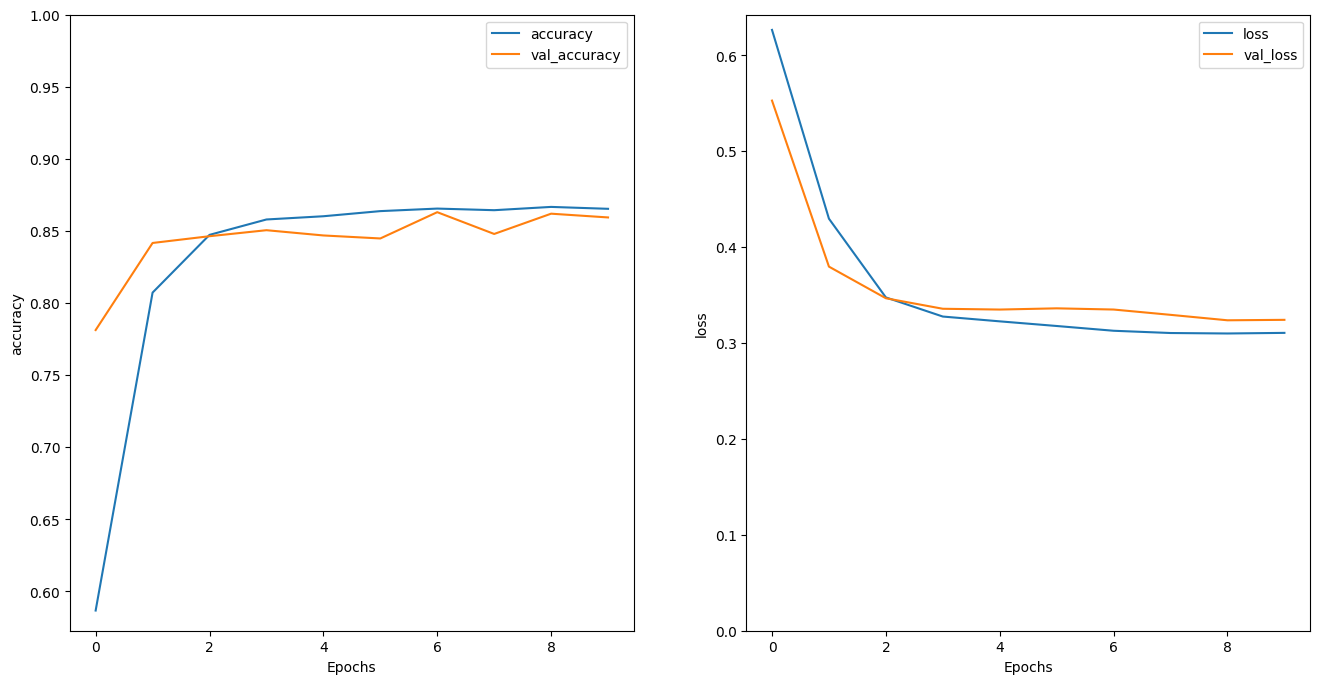

In [43]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [45]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(tf.constant([sample_text]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [46]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [47]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [48]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - accuracy: 0.5155 - loss: 0.6788 - val_accuracy: 0.8151 - val_loss: 0.4556
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - accuracy: 0.8194 - loss: 0.4185 - val_accuracy: 0.8401 - val_loss: 0.3504
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 103ms/step - accuracy: 0.8437 - loss: 0.3595 - val_accuracy: 0.8427 - val_loss: 0.3366
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - accuracy: 0.8570 - loss: 0.3312 - val_accuracy: 0.8557 - val_loss: 0.3295
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 100ms/step - accuracy: 0.8626 - loss: 0.3196 - val_accuracy: 0.8531 - val_loss: 0.3255
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 205ms/step - accuracy: 0.8637 - loss: 0.3144 - val_accuracy: 0.8161 - val_loss: 0.3584
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 101ms/step - accuracy: 0.8627 - loss: 0.3161 - val_accuracy: 0.8328 - val_loss: 0.3368
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.8656 - loss: 0

In [51]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.8627 - loss: 0.3322
Test Loss: 0.3296646475791931
Test Accuracy: 0.8624399900436401


In [53]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(tf.constant([sample_text]))
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[-1.75756]]


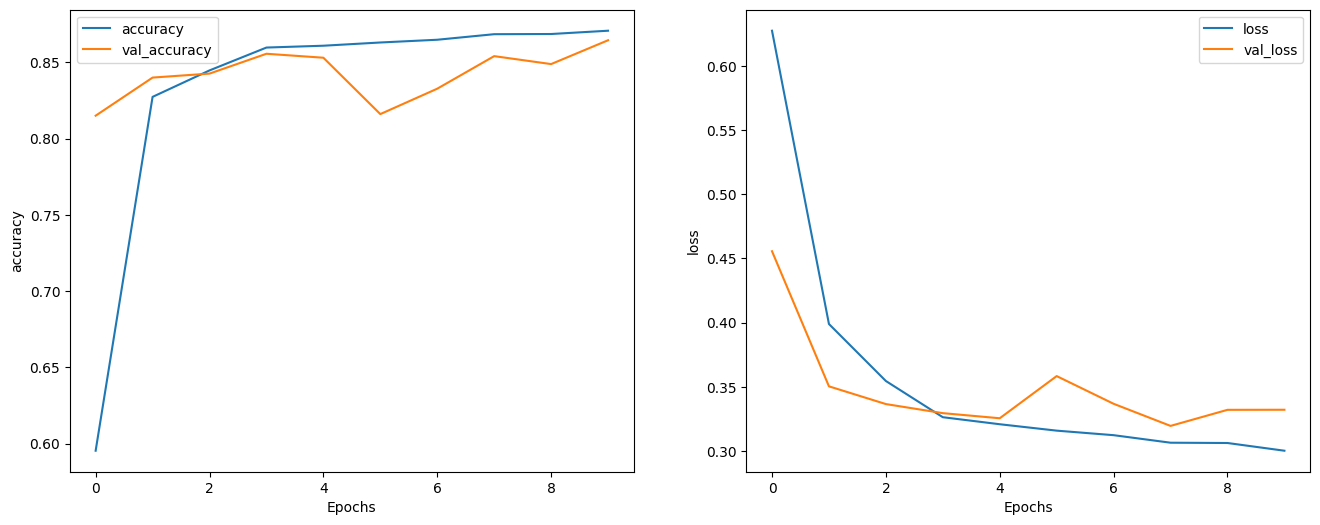

In [50]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
